## Function Definition

In [284]:
import numpy as np
import json
import json5
import graphviz
import os
from IPython.display import display, Image

GLOBAL_SEED = 13520144
def linear(x, drv=False):
    if not drv:
        return x
    else:
        return 1

def relu(x, drv=False):
    if not drv:
        return np.maximum(0, x)
    else:
        return 1. * (x > 0)

def sigmoid(x, drv=False):
    if not drv:
        return 1 / (1 + np.exp(-x))
    else:
        return sigmoid(x) * (1 - sigmoid(x))

def softmax(x, drv=False):
    if not drv:
        x = x - np.max(x, axis=-1, keepdims=True)
        y = np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
        return y
    else:
        return 1

def mse(x, target, drv=False):
    return np.sum((x - target) ** 2)

def cross_entropy(x, target, drv=False):
    return -np.sum(target * np.log(x))

def minmaxscaler(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def weights_scaler(x):
    return 2 * minmaxscaler(x) - 1

## Class Definition

In [285]:
class FFNN:
    def __init__(self, n_neuron_each_layer=None, actfns=None, preweight=None, rand_seed=None):
        if n_neuron_each_layer is None:
            n_neuron_each_layer = [1, 1]
        self.Wdict = {}
        n_layer = len(n_neuron_each_layer)
        if actfns is None:
            actfns = ["linear"] * n_layer
        assert n_layer >= 2, "n_neuron_each_layer must have at least 2 elements (Input and Output)"
        assert all((isinstance(s, str) and callable(eval(s))) for s in actfns), "actfns must be a list of strings of callable functions"
        self.n_layer = n_layer
        self.n_neuron = n_neuron_each_layer
        self.actfns = [eval(s) for s in actfns]
        if preweight is None:
            for i in range(1, n_layer):
                if rand_seed is not None:
                    np.random.seed(rand_seed)
                # Random weights using LeCun's normal initialization (Efficient Backprop)
                limit = np.sqrt(3 / n_neuron_each_layer[i-1])
                self.Wdict[f'{i-1}-to-{i}'] = np.random.normal(0.0, limit, size=(n_neuron_each_layer[i-1]+1, n_neuron_each_layer[i]))
        else:
            assert len(preweight) == n_layer - 1
            preweight = [np.array(w) for w in preweight]
            for i in range(1, n_layer):
                assert preweight[i-1].shape[0] == n_neuron_each_layer[i-1]+1
                assert preweight[i-1].shape[1] == n_neuron_each_layer[i]
                self.Wdict[f'{i-1}-to-{i}'] = preweight[i-1]

    def forward(self, data, return_acts=False):
        assert data.ndim == 2
        assert data.shape[1] == self.n_neuron[0]
        acts = []
        for i, (k, v) in enumerate(self.Wdict.items()):
            data = np.hstack((np.ones((data.shape[0], 1)), data))
            acts.append(data)
            data = self.actfns[i](data @ v)
        acts.append(data)
        return acts if return_acts else acts[-1]

    def backward(self, x, y, i):
        acts = self.forward(x, return_acts=True)
        if self.actfns[-1] == softmax:
            err = -y * (1 - acts[-1]) + (1 - y) * acts[-1]
        else:
            err = acts[-1] - y

        grads = [err * self.actfns[-1](acts[-1], drv=True)]

        for layer in range(self.n_layer-2, 0, -1):
            grad = grads[0].dot(self.Wdict[f'{layer}-to-{layer+1}'].T)
            drv_act = self.actfns[layer-1](acts[layer], drv=True)
            grad = grad * drv_act
            grad = grad[:, 1:] 
            grads.insert(0, grad)

        return acts, grads

    def fit(self, x, y, max_iter=10, lr=0.1, batch_size=None, err_threshold=None, verbose=False):
        assert x.ndim == 2
        assert x.shape[1] == self.n_neuron[0]
        # scale x
        x = minmaxscaler(x)
        # one hot encode y
        n_classes = len(np.unique(y))
        y = np.eye(n_classes)[y]
        for epoch in range(max_iter):
            idx = range(0, x.shape[0], batch_size)
            rand_idx = np.random.permutation(idx)
            for i in rand_idx:
                acts, grads = self.backward(x[i:i+batch_size], y[i:i+batch_size], i)
                # Update
                for layer in range(self.n_layer - 1):
                    delta = acts[layer].T.dot(grads[layer])
                    self.Wdict[f'{layer}-to-{layer+1}'] -= lr * delta

            if (self.actfns[-1] == softmax):
                err = cross_entropy(self.forward(x), y)
            else:
                err = mse(self.forward(x), y)

            if verbose:
                if epoch % verbose == 0:
                    print(f'epoch {epoch}, error {err}')

            if err_threshold is not None and err < err_threshold:
                break
    
    def predict(self, x):
        x = minmaxscaler(x)
        y_pred = np.argmax(self.forward(x), axis=1)
        return y_pred

    def savetojson(self, filename):
        assert filename.endswith('.json')
        with open(filename, 'w') as f:
            data = {
                "n_neuron_each_layer": self.n_neuron,
                "actfns": [
                    "linear" if fn == linear else
                    "relu" if fn == relu else
                    "sigmoid" if fn == sigmoid else
                    "softmax" if fn == softmax else
                    "unknown"
                    for fn in self.actfns
                ],
                "preweight": [v.tolist() for k, v in self.Wdict.items()]
            }
            json.dump(data, f)

    @staticmethod
    def loadfromjson(filename):
        assert filename.endswith('.json')
        with open(filename, 'r') as f:
            data = json.load(f)
            return FFNN(data['n_neuron_each_layer'], data['actfns'], data['preweight'])

    def draw(self):
        graph = graphviz.Digraph(engine='neato')
        graph.attr(rankdir='LR')
        layer_spacing = 3  # Increase this value to increase the space between layers
        node_spacing = 2  # Increase this value to increase the space between nodes
        for i in range(self.n_layer):
            if i != self.n_layer - 1:
                graph.node(f'b_{i}', group=f'cluster_{i}', id=f"bias_{i}", pos=f'{i*layer_spacing},0!')
            for j in range(self.n_neuron[i]):
                graph.node(f'{i}_{j}', group=f'cluster_{i}',  pos=f'{i*layer_spacing},{-(j+1)*node_spacing}!')
        #Edges
        # List of colors to use for the edges
        colors = ['red', 'blue', 'green', 'purple', 'orange',
                  'brown', 'magenta', 'olive', 'navy']
        color_index = 0
        for layer in range(self.n_layer - 1):
            for cur_layer_i in range(-1, self.n_neuron[layer]):
                for next_layer_i in range(self.n_neuron[layer+1]):
                    tgt = f"{layer+1}_{next_layer_i}"
                    if cur_layer_i == -1:
                        src = f"b_{layer}"
                        bias = self.Wdict[f'{layer}-to-{layer+1}'][0,next_layer_i]
                        label = f'<<table border="0" cellborder="0"><tr><td></td></tr><tr><td>{bias:.2f}</td></tr></table>>'
                    else:
                        src = f"{layer}_{cur_layer_i}"
                        # Get the weight value for edge (src, tgt)
                        weight = self.Wdict[f'{layer}-to-{layer+1}'][cur_layer_i+1, next_layer_i]
                        label = f'<<table border="0" cellborder="0"><tr><td></td></tr><tr><td>{weight:.2f}</td></tr></table>>'
                    color = colors[color_index % len(colors)]
                    color_index += 1
                    graph.edge(src, tgt, label=label, color=color, fontcolor=color)

        graph.format = 'png'
        display(Image(graph.render('FFNN Graph')))


epoch 0, error 139.91064937163586
epoch 5, error 86.40026044234766
epoch 10, error 65.87144054952003
epoch 15, error 54.396449509054364
epoch 20, error 43.08320446877935
epoch 25, error 32.81011972626523
epoch 30, error 25.903863152082756
Accuracy 0.9333333333333333


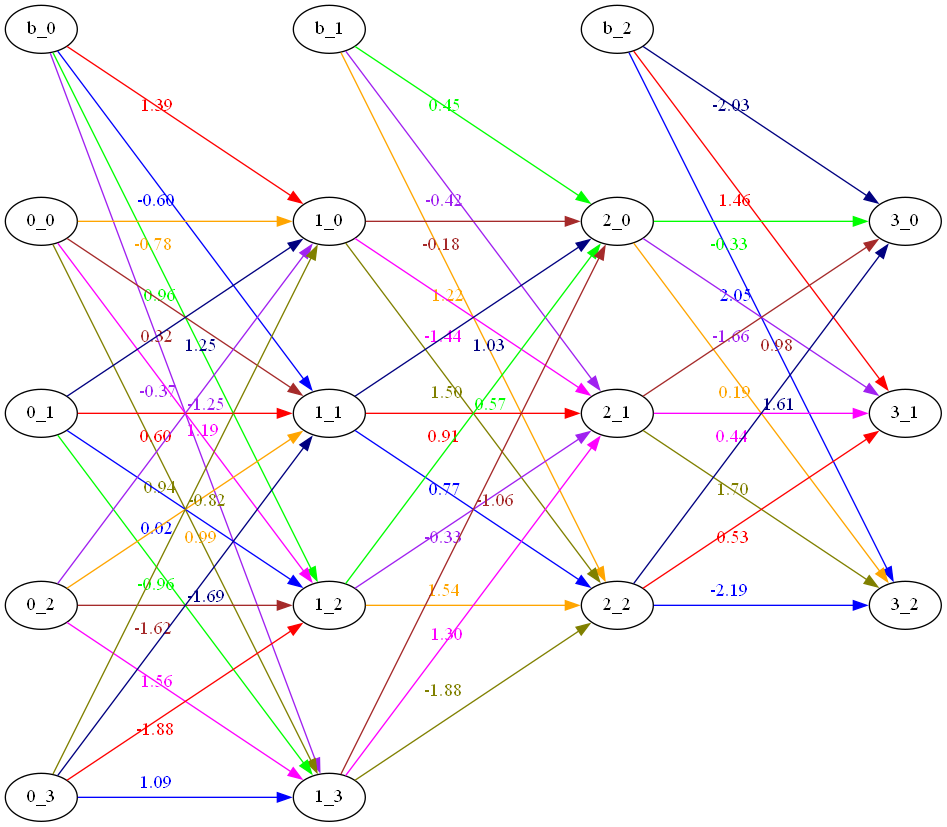

In [309]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
# reminder: implement stop at err < err_thres
data = load_iris()
x = data['data']
y = data['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
m = FFNN([4, 4, 3, 3], ['relu', 'relu', 'softmax'], rand_seed=69)
m.fit(x_train, y_train, max_iter=100, lr=0.01, batch_size=5, err_threshold=25, verbose=5)
y_pred = m.predict(x_test)

print("Accuracy", np.sum(y_pred == y_test) / len(y_test))

m.savetojson('iris.json')
m.draw()

[[-0.10085674]
 [-4.50925226]
 [-7.63656624]
 [ 3.01671649]
 [-8.24564786]
 [-0.37294022]
 [-0.66943588]
 [-6.41357777]
 [-5.51014448]
 [-6.97873582]]


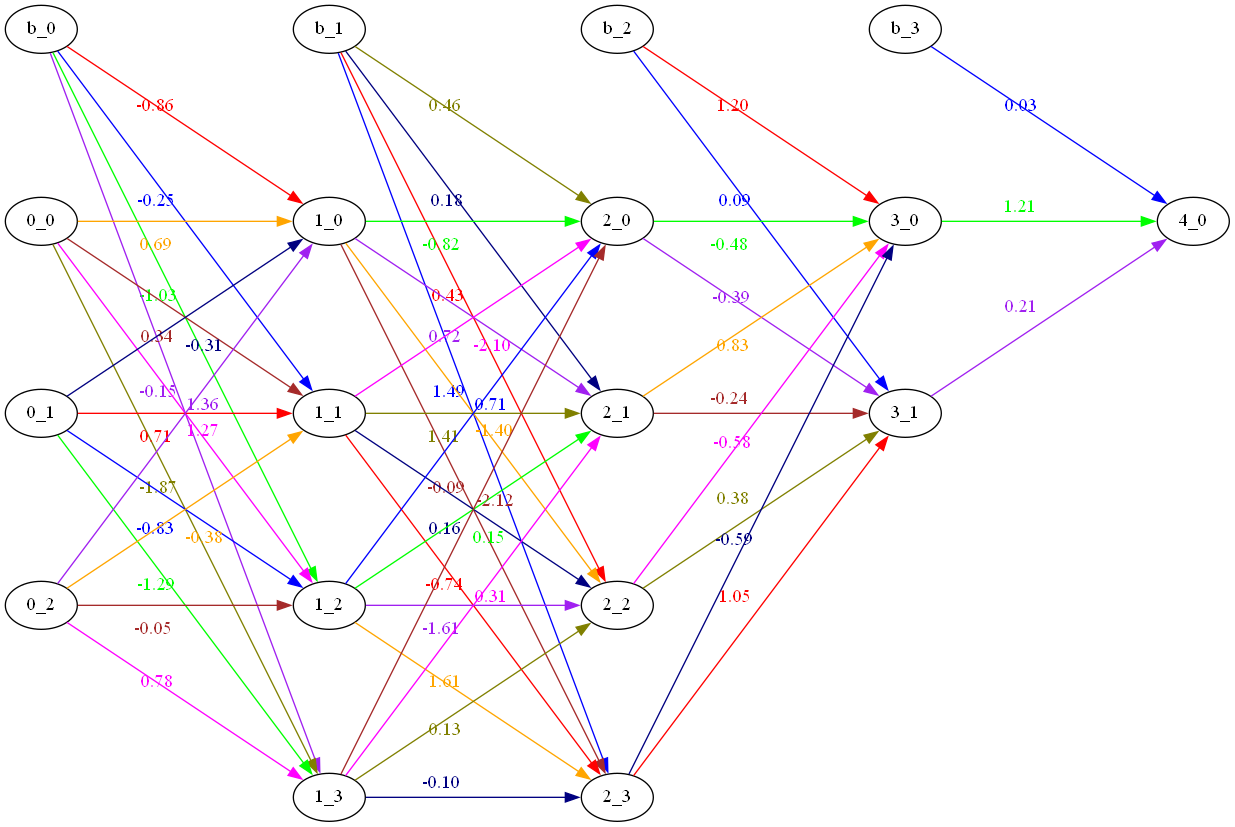

In [287]:
ff = FFNN([3, 4, 4, 2, 1])
np.random.seed(GLOBAL_SEED)
print(ff.forward(np.random.randn(10, 3)))
ff.savetojson('test.json')
ff.draw()

In [288]:
ff2 = FFNN.loadfromjson('test.json')
np.random.seed(GLOBAL_SEED)
print(ff2.forward(np.random.randn(10, 3)))

[[-0.10085674]
 [-4.50925226]
 [-7.63656624]
 [ 3.01671649]
 [-8.24564786]
 [-0.37294022]
 [-0.66943588]
 [-6.41357777]
 [-5.51014448]
 [-6.97873582]]


In [289]:
def test_model(tc_filename):
    print(f"=== Testing {tc_filename} ===")
    with open(tc_filename, 'r') as f:
        data = json5.load(f)
        n_neuron_each_layer = []
        actfns = []
        preweight = data['case']['weights']
        n_neuron_each_layer.append(data['case']['model']['input_size'])
        for layer in data['case']['model']['layers']:
            n_neuron_each_layer.append(layer['number_of_neurons'])
            actfns.append(layer['activation_function'])
        input_data = np.array(data['case']['input'])
        model = FFNN(n_neuron_each_layer, actfns, preweight)
        output = model.forward(input_data)
        output_expected = np.array(data['expect']['output'])
        if output.shape[0] == output_expected.shape[1] and output.shape[1] == output_expected.shape[0]:
            output_expected = output_expected.T
        maximum_error = data['expect']['max_sse']
        # calculate output error
        output_error = np.sum((output - output_expected) ** 2)
        print(f'output: {output}')
        print(f'expected output: {output_expected}')
        print(f'output error: {output_error}')
        print(f'expected output error: {maximum_error}')
        print(f'output error <= expected output error: {output_error <= maximum_error}')
        print()


tc_folder = 'testcase'
tc_filename = [
    'linear.json',
    'multilayer.json',
    'relu.json',
    'sigmoid.json',
    'softmax.json',
]
for filename in tc_filename:
    test_model(os.path.join(tc_folder, filename))


=== Testing testcase\linear.json ===
output: [[ 2.   0.3 -1.9]]
expected output: [[ 2.   0.3 -1.9]]
output error: 2.2494861750442915e-31
expected output error: 1e-06
output error <= expected output error: True

=== Testing testcase\multilayer.json ===
output: [[2. 0.]
 [0. 2.]
 [0. 0.]]
expected output: [[2. 0.]
 [0. 2.]
 [0. 0.]]
output error: 0.0
expected output error: 1e-06
output error <= expected output error: True

=== Testing testcase\relu.json ===
output: [[0.05 1.1  0.  ]]
expected output: [[0.05 1.1  0.  ]]
output error: 4.8148248609680896e-33
expected output error: 1e-06
output error <= expected output error: True

=== Testing testcase\sigmoid.json ===
output: [[0.61774787 0.58904043 0.57444252]]
expected output: [[0.617747 0.58904  0.574442]]
output error: 1.2207224545374987e-12
expected output error: 1e-06
output error <= expected output error: True

=== Testing testcase\softmax.json ===
output: [[0.66524096 0.09003057 0.24472847]]
expected output: [[0.665241 0.090031 0.24